In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from datetime import datetime, timedelta
import time
import seaborn as sns
import pickle
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
import itertools

In [251]:
# the number of days used in the simulation script: find_size_allparam.py
num_days = 10
CPU_case = False
dynamic_quota = False
dynamic_quota_speed = 0.2

job_agg = True  # whether to subsample the data
daily_job_number = 150 if not CPU_case else 150

# Plots for Mean Value

We need to load and concate all the data files for a specific cluster
Our stored result contain information for each day and each month. Here for simplicity we consider their average

In [252]:
if not CPU_case:
    cluster_name = 'Saturn'
    root_path = os.path.join(os.getcwd(), 'results', cluster_name)
else:
    root_path = os.path.join(os.getcwd(), 'results', 'ORNL')
# based on this name, we get the list of all the result file names
if not dynamic_quota:
    flex_file_names = [file_name for file_name in os.listdir(root_path) if ('flex_all_ms_dict' in file_name) & ('dq' not in file_name) & ('cmin' not in file_name) & ('numdays' not in file_name)]
else:
    flex_file_names = [file_name for file_name in os.listdir(root_path) if ('flex_all_ms_dict' in file_name) & (f'dq{dynamic_quota_speed}' in file_name) & ('cmin' not in file_name) & ('numdays' not in file_name)]

Pmax_CPU = 18688/180
Pmax_GPU = 2104/20 # the max number of GPU is 2104, and the max number of CPU is 18688

Pmax = Pmax_CPU if CPU_case else Pmax_GPU

In [253]:
# among the files, the first number stands for the max delay
# the second number stands for the duration
# the third number stands for the frequency
# we need to create dfs for each max delay, in which the columns are the frequencies and the rows are the durations

# 1. get all the possible max delays based on these file names, via regularisation extracting the first number optionally including the dot
import re
max_delays = list(np.unique([float(re.findall('\d+(?:\.|)(?:\d+|)', file_name)[0]) for file_name in flex_file_names]))
durations = np.unique([float(re.findall('\d+(?:\.|)(?:\d+|)', file_name)[1]) for file_name in flex_file_names])
frequencies = np.unique([float(re.findall('\d+(?:\.|)(?:\d+|)', file_name)[2]) for file_name in flex_file_names])
start_date_str_list = np.unique([file_name.split('_')[-1].split('.')[0] for file_name in flex_file_names])

def read_data_all_dates(file_name, start_date_str_list):
    data_list = []
    for start_date_str in start_date_str_list:
        file_name_date = file_name + f'_{start_date_str}.pkl'
        # first judge if the file exists
        if not os.path.exists(os.path.join(root_path, file_name_date)):
            print(f'{file_name_date} does not exist')
            return [np.nan] * len(start_date_str_list)
        with open(os.path.join(root_path, file_name_date), 'rb') as f:
            data_list.append(pickle.load(f)[start_date_str])
    return data_list

def stp_zeros(x):
    return str(x).rstrip('0').rstrip('.')

max_delays_plot = max_delays

res_df_dict = {}
rel_res_df_dict = {}
gap_mean_df_dict = {}
gap_max_df_dict = {}
gap_abs_mean_df_dict = {}
gap_abs_max_df_dict = {}
for max_delay in max_delays:
    res_df_dict[max_delay] = pd.DataFrame(index = durations, columns = frequencies)
    rel_res_df_dict[max_delay] = pd.DataFrame(index = durations, columns = frequencies)
    gap_mean_df_dict[max_delay] = pd.DataFrame(index = durations, columns = frequencies)
    gap_max_df_dict[max_delay] = pd.DataFrame(index = durations, columns = frequencies)
    gap_abs_mean_df_dict[max_delay] = pd.DataFrame(index = durations, columns = frequencies)
    gap_abs_max_df_dict[max_delay] = pd.DataFrame(index = durations, columns = frequencies)
    # then I need to load e data from the file and put it in the right place

    for duration, frequency in list(itertools.product(durations, frequencies)):
        flex_size_file_name_base = f'flex_all_ms_dict_{stp_zeros(max_delay)}_D{duration}F{stp_zeros(frequency)}_{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}{f"_agg{daily_job_number}" if job_agg else ""}'
        flex_data_list = read_data_all_dates(flex_size_file_name_base, start_date_str_list)
        pbase_data_list = read_data_all_dates(flex_size_file_name_base.replace('flex_all_ms_dict', 'pbase_flex_all_dict'), start_date_str_list)
        gap_data_list = read_data_all_dates(flex_size_file_name_base.replace('flex_all_ms_dict', 'MIPgap_all_dict'), start_date_str_list)
        # replace np.inf in gap_data_list with 0. this is because the best objective found is zero, so the relgap is inf. When the max flex is 0, the abs gap is also 0
        gap_data_list = [0 if x == np.inf else x for x in gap_data_list]
        
        if np.all(np.isnan(np.hstack(flex_data_list))):
            res_mean = np.nan
            rel_res_mean = np.nan
            gap_res_mean = np.nan
            gap_res_max = np.nan
            gap_abs_res_mean = np.nan
            gap_abs_res_max = np.nan
        else:
            # the mean should skip nan values and treat negative values as 0
            res_mean = np.nanmean(np.hstack(flex_data_list).clip(min = 0))
            
            rel_res_list = []
            gap_abs_res_list = []
            # get the mean value of all the arrays of the dict
            for i in range(len(flex_data_list)):
                rel_res_list.append(flex_data_list[i].flatten() / pbase_data_list[i].mean(axis = 1).flatten())
                gap_abs_res_list.append(gap_data_list[i] * flex_data_list[i].mean())

            rel_res_mean = np.nanmean(np.hstack(rel_res_list).clip(min = 0))
            
            gap_res_mean = np.nanmean(np.hstack(gap_data_list))
            gap_res_max = np.nanmax(np.hstack(gap_data_list))
            gap_abs_res_mean = np.nanmean(np.hstack(gap_abs_res_list))
            gap_abs_res_max = np.nanmax(np.hstack(gap_abs_res_list))

        
        # normalise the results by the max baseline power

        res_df_dict[max_delay].loc[duration, frequency] = res_mean / Pmax
        rel_res_df_dict[max_delay].loc[duration, frequency] = rel_res_mean
        gap_mean_df_dict[max_delay].loc[duration, frequency] = gap_res_mean
        gap_max_df_dict[max_delay].loc[duration, frequency] = gap_res_max
        gap_abs_mean_df_dict[max_delay].loc[duration, frequency] = gap_abs_res_mean / Pmax
        gap_abs_max_df_dict[max_delay].loc[duration, frequency] = gap_abs_res_max / Pmax


C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_41708\769567513.py:68: RuntimeWarning: invalid value encountered in divide
  rel_res_list.append(flex_data_list[i].flatten() / pbase_data_list[i].mean(axis = 1).flatten())
C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_41708\769567513.py:68: RuntimeWarning: invalid value encountered in divide
  rel_res_list.append(flex_data_list[i].flatten() / pbase_data_list[i].mean(axis = 1).flatten())
C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_41708\769567513.py:68: RuntimeWarning: invalid value encountered in divide
  rel_res_list.append(flex_data_list[i].flatten() / pbase_data_list[i].mean(axis = 1).flatten())
C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_41708\769567513.py:68: RuntimeWarning: invalid value encountered in divide
  rel_res_list.append(flex_data_list[i].flatten() / pbase_data_list[i].mean(axis = 1).flatten())
C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_41708\769567513.py:68: RuntimeWarning: invalid value encountered in divi

In [254]:
res_df_dict[0.2]

10.0      20.0      40.0      80.0      120.0     240.0     480.0  \
0.25   0.690131  0.685194  0.683672  0.665998  0.592962  0.329491  0.119733   
0.50   0.679769  0.653066  0.650711  0.517061  0.345269  0.119476       0.0   
1.00   0.654906  0.642303  0.510782  0.232555  0.120938       0.0       NaN   
2.00   0.605011  0.448019  0.224495  0.060677       0.0       NaN       NaN   
3.00    0.48216  0.307328  0.119577       0.0       NaN       NaN       NaN   
6.00   0.274809  0.113677       0.0       NaN       NaN       NaN       NaN   
12.00  0.098523       0.0       NaN       NaN       NaN       NaN       NaN   
24.00       0.0       NaN       NaN       NaN       NaN       NaN       NaN   

      960.0  
0.25    0.0  
0.50    NaN  
1.00    NaN  
2.00    NaN  
3.00    NaN  
6.00    NaN  
12.00   NaN  
24.00   NaN

## Heatmaps for each delay (Normalised Flex)

In [255]:
def symmetric_metric(df):    
    mat = df.copy().values
    metric = []
    for i in range(1, mat.shape[0]):
        for j in range(np.min([i, mat.shape[1] - i])):
            if np.isnan(mat[i,j]) or np.isnan(mat[j,i]):
                continue
            metric.append((mat[i,j] - mat[j,i]) / (np.max([mat[i,j],mat[j,i]]) + 1e-7))
    metric = np.mean(metric)
    return metric

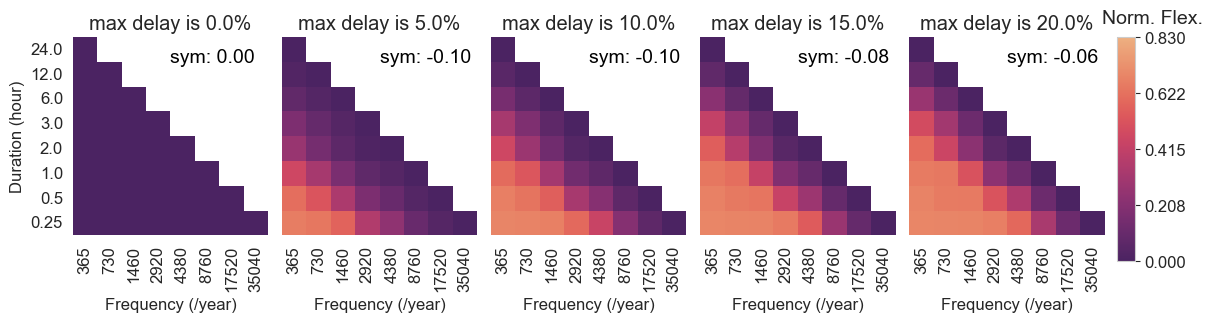

In [256]:
# year scaler. the frequency recorded is for (num_days) day, so we need to scale it to a year
year_scaler = 365 / (num_days) # 365 as the data is for 2020, which is a leap year

# enlarge the font size
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(1, len(max_delays_plot), figsize=[2.4*len(max_delays_plot),3.2])

color_map = sns.color_palette("flare_r", as_cmap=True)
vmin, vmax = 0, 0.83
ticks = [np.round(v, 3) for v in np.linspace(vmin, vmax, 5)]

for i, max_delay in enumerate(max_delays_plot):
    df = res_df_dict[max_delay].copy()
    # before plotting, I need to round the number of the column and row names to 2 digits
    df.index = np.round(df.index, 2)
    df.columns = (df.columns * year_scaler).astype(int)

    sns.heatmap(df.astype('float').iloc[::-1], cmap = color_map, vmin = vmin, vmax=vmax, mask=df.iloc[::-1].isnull(), cbar_kws={"ticks":ticks, 'label': 'kW'}, ax= axs[i], cbar=False)
    axs[i].set_xlabel('Frequency (/year)')
    axs[i].set_ylabel('Duration (hour)')
    # turn off grid
    axs[i].grid(False)
    axs[i].set_title(f"max delay is {max_delay*100}%")
    # hide the yaxis except the first
    if i != 0:
        axs[i].set_yticklabels([])
        # hide ylkabels
        axs[i].set_ylabel('')
        
    # calculate the symmetric metric score and display it in the upper right corner
    axs[i].text(0.5, 0.9, f'sym: {symmetric_metric(df):.2f}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')

# adjust the space between subplots
fig.subplots_adjust(wspace=0.07, hspace=0.1, top=0.9, bottom=0.28, left=0.06, right=0.92)

# plot color bar
cbar_ax = fig.add_axes([0.93, 0.2, 0.015, 0.7])
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color_map), cax=cbar_ax, ticks=ticks)
# add a label kW on top of color bar.
cbar_ax.set_title('Norm. Flex.', fontsize=14, pad=10, x=2)

# save the figure
plt.savefig(os.path.join(os.getcwd(), 'plots', f'normalised_flex_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pdf'), dpi = 300)

plt.show()

# save res_df_dict
with open(os.path.join(os.getcwd(), 'plots', 'plot_data', f'flex_size_df_dict_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pkl'), 'wb') as f:
    pickle.dump(res_df_dict, f)

In [257]:
# fig, axs = plt.subplots(1, len(max_delays_plot), figsize=[5*len(max_delays_plot),4])
# 
# color_map = sns.color_palette("rocket_r", as_cmap=True)
# vmin, vmax = 0, 1
# ticks = [np.round(v, 3) for v in np.linspace(vmin, vmax, 5)]
# 
# for i, max_delay in enumerate(max_delays_plot):
#     df = rel_res_df_dict[max_delay].copy()
#     # before plotting, I need to round the number of the column and row names to 2 digits
#     df.index = np.round(df.index, 2)
#     df.columns = np.round(df.columns, 2) * year_scaler
# 
#     sns.heatmap(df.astype('float').iloc[::-1], cmap = color_map, vmin = vmin, vmax=vmax, mask=df.iloc[::-1].isnull(), cbar_kws={"ticks":ticks, 'label': 'kW'}, ax=axs[i])
#     axs[i].set_xlabel('Frequency (/year)')
#     axs[i].set_ylabel('Duration (hour)')
#     # turn off grid
#     axs[i].grid(False)
#     axs[i].set_title(f"max delay is {max_delay*100}%")
#     
# # set a title for the whole figure
# fig.suptitle('Relative Flexibility', fontsize=16)
# plt.show()

## Heatmap for MIP abs gap

In [258]:
data_dict = gap_abs_mean_df_dict

# find the max value among all the dataframes
vmax = 0
for max_delay in max_delays:
    vmax = max(vmax, data_dict[max_delay].max().max())
print(f'the max value is {vmax}')

the max value is 0


In [259]:
# fig, axs = plt.subplots(1, len(max_delays_plot), figsize=[5*len(max_delays_plot),4])
# 
# color_map = sns.color_palette("rocket_r", as_cmap=True)
# vmin, vmax = 0, 0.014
# ticks = [np.round(v, 3) for v in np.linspace(vmin, vmax, 5)]
# 
# for i, max_delay in enumerate(max_delays_plot):
#     df = data_dict[max_delay].copy()
#     # before plotting, I need to round the number of the column and row names to 2 digits
#     df.index = np.round(df.index, 2)
#     df.columns = np.round(df.columns, 2) * year_scaler
# 
#     sns.heatmap(df.astype('float').iloc[::-1], cmap = color_map, vmin = vmin, vmax=vmax, mask=df.iloc[::-1].isnull(), cbar_kws={"ticks":ticks, 'label': 'kW'}, ax=axs[i])
#     axs[i].set_xlabel('Frequency (/year)')
#     axs[i].set_ylabel('Duration (hour)')
#     # turn off grid
#     axs[i].grid(False)
#     axs[i].set_title(f"max delay is {max_delay*100}%")
#     
# # set a title for the whole figure
# fig.suptitle('MIP Abs Gap', fontsize=16)
# plt.show()

# Cost Calculation 

In [260]:
# # the price is $/hr, based on https://puzl.cloud/gpu-cloud
# GPU_hr_price = 1.6
# GPU_TDP = 0.25 # kW
# 
# CPU_hr_price = 1.6 # based on Angel's data on EPYC 7742
# CPU_TDP = 0.225 # kW
# 
# hr_price = CPU_hr_price if CPU_case else GPU_hr_price
# TDP = CPU_TDP if CPU_case else GPU_TDP

## Heatmaps for each level (Cost)

In [261]:
levels = [0.3, 0.6, 1]
max_delay = 0.2

comp_cost_res_df_dict = {}
energy_cost_res_df_dict = {}

cost_gap_mean_df_dict = {}
cost_gap_max_df_dict = {}
cost_gap_abs_mean_df_dict = {}
cost_gap_abs_max_df_dict = {}


# based on this name, we get the list of all the result file names
if not dynamic_quota:
    cost_file_names = [file_name for file_name in os.listdir(root_path) if ('cost_all_dict' in file_name) & ('dq' not in file_name)]
else:
    cost_file_names = [file_name for file_name in os.listdir(root_path) if ('cost_all_dict' in file_name) & ('dq' in file_name)]

durations = np.unique([float(re.findall('\d+(?:\.|)(?:\d+|)', file_name)[1]) for file_name in cost_file_names])
frequencies = np.unique([float(re.findall('\d+(?:\.|)(?:\d+|)', file_name)[2]) for file_name in cost_file_names])

for level in levels:
    comp_cost_res_df_dict[level] = pd.DataFrame(index = durations, columns = frequencies)
    energy_cost_res_df_dict[level] = pd.DataFrame(index = durations, columns = frequencies)
    cost_gap_mean_df_dict[level] = pd.DataFrame(index = durations, columns = frequencies)
    cost_gap_max_df_dict[level] = pd.DataFrame(index = durations, columns = frequencies)
    cost_gap_abs_mean_df_dict[level] = pd.DataFrame(index = durations, columns = frequencies)
    cost_gap_abs_max_df_dict[level] = pd.DataFrame(index = durations, columns = frequencies)
    # then I need to load e data from the file and put it in the right place

    for duration, frequency in list(itertools.product(durations, frequencies)):
        cost_file_name_base = f'cost_all_dict_{stp_zeros(max_delay)}_D{duration}F{stp_zeros(frequency)}_{f"_level{level}" if level != 1 else ""}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}{f"_agg{daily_job_number}" if job_agg else ""}'
        cost_data_list = read_data_all_dates(cost_file_name_base, start_date_str_list)
        
        # cost contains 1) compensation cost and 2) additional energy cost
        if np.all([item is np.nan for item in cost_data_list]):
            comp_cost_unit = np.nan
            energy_cost_unit = np.nan
            cost_gap_res_mean = np.nan
            cost_gap_res_max = np.nan
            cost_gap_abs_res_mean = np.nan
            cost_gap_abs_res_max = np.nan
        else:     
            comp_cost_data_list = np.array([item['comp'] for item in cost_data_list])
            energy_cost_data_list = np.array([item['energy_cost'] for item in cost_data_list])
            
            
            if np.all(np.isnan(comp_cost_data_list)):
                comp_cost_unit = np.nan
                energy_cost_unit = np.nan
                cost_gap_res_mean = np.nan
                cost_gap_res_max = np.nan
                cost_gap_abs_res_mean = np.nan
                cost_gap_abs_res_max = np.nan
            else:
                
                other_file_name_base = f'cost_all_dict_{stp_zeros(max_delay)}_D{duration}F{stp_zeros(frequency)}__cmin{f"_level{level}" if level != 1 else ""}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}{f"_agg{daily_job_number}" if job_agg else ""}'
                flex_data_list = read_data_all_dates(other_file_name_base.replace('cost_all_dict', 'flex_all_ms_dict'), start_date_str_list)
                cost_gap_data_list = read_data_all_dates(other_file_name_base.replace('cost_all_dict', 'MIPgap_all_dict'), start_date_str_list)
                # replace np.inf in gap_data_list with 0. this is because the best objective found is zero, so the relgap is inf. When the max flex is 0, the abs gap is also 0
                cost_gap_data_list = [0 if x == np.inf else x for x in cost_gap_data_list]
            
                # next we find the cost per unit of flex
                # replace None with Nan
                energy_cost_data_list = np.array([item if item is not None else np.nan for item in energy_cost_data_list])
                cost_gap_data_list = np.array([item if item is not None else np.nan for item in cost_gap_data_list])
                
                unit_normaliser = np.vstack(flex_data_list).sum(axis = 1) * duration
                comp_cost_data_list /= unit_normaliser
                energy_cost_data_list /= unit_normaliser
                
                comp_cost_unit = np.nanmean(comp_cost_data_list)
                energy_cost_unit = np.nanmean(energy_cost_data_list)
    
                cost_gap_abs_res_list = []
                # get the mean value of all the arrays of the dict
                for i in range(len(comp_cost_data_list)):
                    cost_gap_abs_res_list.append(cost_gap_data_list[i] * comp_cost_data_list[i].mean())
                
                cost_gap_res_mean = np.nanmean(np.hstack(cost_gap_data_list))
                cost_gap_res_max = np.nanmax(np.hstack(cost_gap_data_list))
                cost_gap_abs_res_mean = np.nanmean(np.hstack(cost_gap_abs_res_list))
                cost_gap_abs_res_max = np.nanmax(np.hstack(cost_gap_abs_res_list))

        
        # normalise the results by the max baseline power

        comp_cost_res_df_dict[level].loc[duration, frequency] = comp_cost_unit
        energy_cost_res_df_dict[level].loc[duration, frequency] = energy_cost_unit
        
        cost_gap_mean_df_dict[level].loc[duration, frequency] = cost_gap_res_mean
        cost_gap_max_df_dict[level].loc[duration, frequency] = cost_gap_res_max
        cost_gap_abs_mean_df_dict[level].loc[duration, frequency] = cost_gap_abs_res_mean
        cost_gap_abs_max_df_dict[level].loc[duration, frequency] = cost_gap_abs_res_max

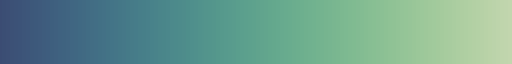

In [262]:
color_map = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True, dark=0.3, light=0.8)
color_map

In [263]:
comp_cost_res_df_dict[level].min().min()

0.5265081089204637

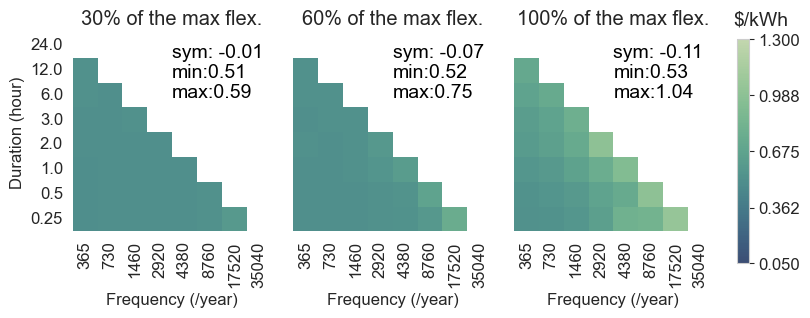

In [264]:
# make a 1*levels plot
fig, axs = plt.subplots(1, len(levels), figsize=[8,3.2])
for i, level in enumerate(levels):
    df = comp_cost_res_df_dict[level].copy() + energy_cost_res_df_dict[level].copy()
    # before plotting, I need to round the number of the column and row names to 2 digits
    df.index = np.round(df.index, 2)
    df.columns = (df.columns * year_scaler).astype(int)

    vmin, vmax = comp_cost_res_df_dict[levels[0]].min().min(), comp_cost_res_df_dict[levels[-1]].max().max()
    vmin, vmax = 0.05, 1.3
    ticks = [np.round(v, 3) for v in np.linspace(vmin, vmax, 5)]
    # ticks[0] += 1e-3
    # ticks[-1] -= 1e-3
    sns.heatmap(df.astype('float').iloc[::-1], cmap = color_map, vmin = vmin, vmax=vmax, mask=df.iloc[::-1].isnull(), cbar_kws={"ticks":ticks, 'label': '$/kWh'}, ax=axs[i], cbar=False)
    axs[i].set_xlabel('Frequency (/year)')
    axs[i].set_ylabel('Duration (hour)')
    # turn off grid
    axs[i].grid(False)
    axs[i].set_title(f"{int(level*100)}% of the max flex.")
    
    # hide the yaxis except the first
    if i != 0:
        axs[i].set_yticklabels([])
        # hide ylkabels
        axs[i].set_ylabel('')
        
    # calculate the symmetric metric score and display it in the upper right corner
    axs[i].text(0.5, 0.9, f'sym: {symmetric_metric(df):.2f}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')
    
    # display the min and max values
    min_value = df.min().min()
    max_value = df.max().max()
    axs[i].text(0.5, 0.8, f'min:{np.round(min_value, 2)}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')
    axs[i].text(0.5, 0.7, f'max:{np.round(max_value, 2)}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')

# adjust the space between subplots
fig.subplots_adjust(wspace=0.11, hspace=0.1, top=0.92, bottom=0.3, left=0.08, right=0.88)

# plot color bar
cbar_ax = fig.add_axes([0.91, 0.2, 0.015, 0.7])
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color_map), cax=cbar_ax, ticks=ticks)
# add a label $/kWh on top of color bar. 
cbar_ax.set_title('$/kWh', fontsize=14, pad=10, x=2)

# save the figure
plt.savefig(os.path.join(os.getcwd(), 'plots', f'unit_cost_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pdf'), dpi = 300)
# set a title for the whole figure
plt.show()

# save comp_cost_res_df_dict and energy_cost_res_df_dict
with open(os.path.join(os.getcwd(), 'plots', 'plot_data', f'comp_cost_res_df_dict_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pkl'), 'wb') as f:
    pickle.dump(comp_cost_res_df_dict, f)
with open(os.path.join(os.getcwd(), 'plots', 'plot_data', f'energy_cost_res_df_dict_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pkl'), 'wb') as f:
    pickle.dump(energy_cost_res_df_dict, f)

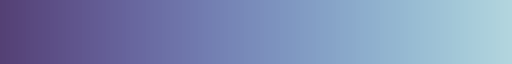

In [265]:
color_map = sns.cubehelix_palette(start=.5, rot=-.4, as_cmap=True, reverse=True, dark=0.3, light=0.8)
color_map

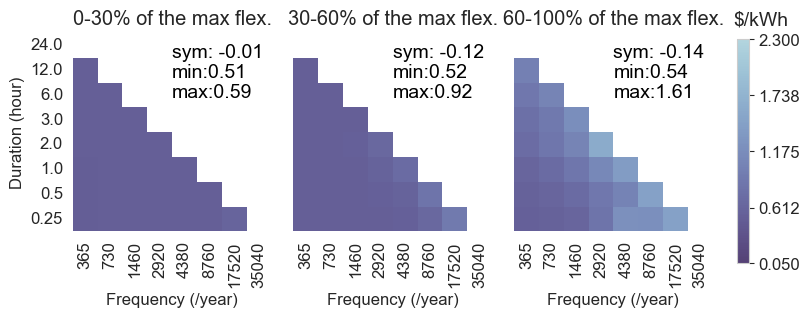

In [266]:
# marginal cost estimation
fig, axs = plt.subplots(1, len(levels), figsize=[8,3.2])

comp_cost_dfs = []
energy_cost_dfs = []

marginal_comp_cost_df_dict = {}
marginal_energy_cost_df_dict = {}

flex_size_dfs = []
for i, level in enumerate(levels):
    flex_size_df = res_df_dict[0.2].copy() * level
    comp_cost_df = comp_cost_res_df_dict[level].copy() * flex_size_df
    energy_cost_df = energy_cost_res_df_dict[level].copy() * flex_size_df
    
    comp_cost_dfs.append(comp_cost_df.copy())
    energy_cost_dfs.append(energy_cost_df.copy())

    flex_size_dfs.append(flex_size_df.copy())
    if i != 0:
        comp_cost_df -= comp_cost_dfs[-2] # -2 is because -1 is itself
        energy_cost_df -= energy_cost_dfs[-2]
        flex_size_df -= flex_size_dfs[-2]
    
    marginal_comp_cost_df = comp_cost_df / flex_size_df
    marginal_energy_cost_df = energy_cost_df / flex_size_df
    
    marginal_comp_cost_df_dict[f"{int(levels[i-1]*100) if i != 0 else 0}-{int(level*100)}%"] = marginal_comp_cost_df.copy()
    marginal_energy_cost_df_dict[f"{int(levels[i-1]*100) if i != 0 else 0}-{int(level*100)}%"] = marginal_energy_cost_df.copy()
    
    df = marginal_comp_cost_df + marginal_energy_cost_df
    # before plotting, I need to round the number of the column and row names to 2 digits
    df.index = np.round(df.index, 2)
    df.columns = (df.columns * year_scaler).astype(int)

    vmin, vmax = 0.05, 2.3
    ticks = [np.round(v, 3) for v in np.linspace(vmin, vmax, 5)]
    # ticks[0] += 1e-3
    # ticks[-1] -= 1e-3
    sns.heatmap(df.astype('float').iloc[::-1], cmap = color_map, vmin = vmin, vmax=vmax, mask=df.iloc[::-1].isnull(), cbar_kws={"ticks":ticks, 'label': '$/kWh'}, ax=axs[i], cbar=False)
    axs[i].set_xlabel('Frequency (/year)')
    axs[i].set_ylabel('Duration (hour)')
    # turn off grid
    axs[i].grid(False)
    axs[i].set_title(f"{int(levels[i-1]*100) if i != 0 else 0}-{int(level*100)}% of the max flex.")
    
    # hide the yaxis except the first
    if i != 0:
        axs[i].set_yticklabels([])
        # hide ylkabels
        axs[i].set_ylabel('')
        
    # calculate the symmetric metric score and display it in the upper right corner
    axs[i].text(0.5, 0.9, f'sym: {symmetric_metric(df):.2f}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')
    
    # display the min and max values
    min_value = df.min().min()
    max_value = df.max().max()
    axs[i].text(0.5, 0.8, f'min:{np.round(min_value, 2)}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')
    axs[i].text(0.5, 0.7, f'max:{np.round(max_value, 2)}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')

# adjust the space between subplots
fig.subplots_adjust(wspace=0.11, hspace=0.1, top=0.92, bottom=0.3, left=0.08, right=0.88)

# plot color bar
cbar_ax = fig.add_axes([0.91, 0.2, 0.015, 0.7])
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color_map), cax=cbar_ax, ticks=ticks)
# add a label $/kWh on top of color bar. 
cbar_ax.set_title('$/kWh', fontsize=14, pad=10, x=2)

# save the figure
plt.savefig(os.path.join(os.getcwd(), 'plots', f'marginal_cost_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pdf'), dpi = 300)
# set a title for the whole figure
plt.show()

# save marginal_comp_cost_df_dict and marginal_energy_cost_df_dict
with open(os.path.join(os.getcwd(), 'plots', 'plot_data', f'marginal_comp_cost_df_dict_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pkl'), 'wb') as f:
    pickle.dump(marginal_comp_cost_df_dict, f)
with open(os.path.join(os.getcwd(), 'plots', 'plot_data', f'marginal_energy_cost_df_dict_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pkl'), 'wb') as f:
    pickle.dump(marginal_energy_cost_df_dict, f)

In [267]:
df

365       730       1460      2920      4380      8760      17520  \
0.25   0.542113  0.565485   0.61663  0.826673   1.21858  1.194382  1.472806   
0.50   0.559051  0.610578   0.70718  0.873674  1.029367   1.47172       NaN   
1.00   0.614608  0.701873  0.856852  1.089387  1.395775       NaN       NaN   
2.00   0.725181  0.851716  1.049099  1.613838       NaN       NaN       NaN   
3.00   0.769789  0.900416  1.185679       NaN       NaN       NaN       NaN   
6.00   0.877289  1.048797       NaN       NaN       NaN       NaN       NaN   
12.00  0.998662       NaN       NaN       NaN       NaN       NaN       NaN   
24.00       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

      35040  
0.25    NaN  
0.50    NaN  
1.00    NaN  
2.00    NaN  
3.00    NaN  
6.00    NaN  
12.00   NaN  
24.00   NaN

## Heatmap for MIP gap

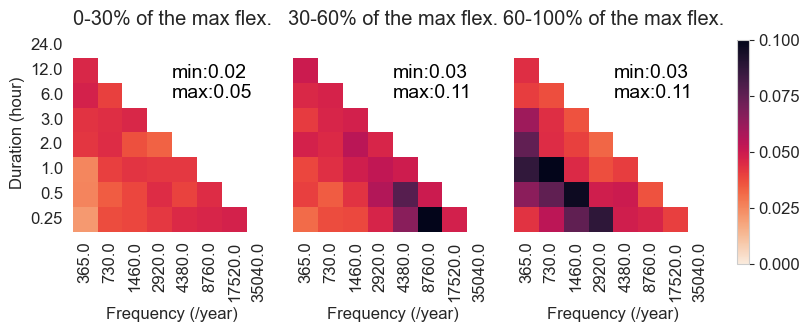

In [268]:
# marginal cost estimation
fig, axs = plt.subplots(1, len(levels), figsize=[8,3.2])

data_dict = cost_gap_mean_df_dict

color_map = sns.color_palette("rocket_r", as_cmap=True)
vmin, vmax = 0, 0.1
ticks = [np.round(v, 3) for v in np.linspace(vmin, vmax, 5)]

for i, level in enumerate(levels):
    df = data_dict[level].copy()
    # before plotting, I need to round the number of the column and row names to 2 digits
    df.index = np.round(df.index, 2)
    df.columns = np.round(df.columns, 2) * year_scaler

    sns.heatmap(df.astype('float').iloc[::-1], cmap = color_map, vmin = vmin, vmax=vmax, mask=df.iloc[::-1].isnull(), cbar_kws={"ticks":ticks, 'label': 'kW'}, ax=axs[i], cbar=False)
    axs[i].set_xlabel('Frequency (/year)')
    axs[i].set_ylabel('Duration (hour)')
    # turn off grid
    axs[i].grid(False)
    axs[i].set_title(f"{int(levels[i-1]*100) if i != 0 else 0}-{int(level*100)}% of the max flex.")
    
    # hide the yaxis except the first
    if i != 0:
        axs[i].set_yticklabels([])
        # hide ylkabels
        axs[i].set_ylabel('')
    
    # display the min and max values
    min_value = df.min().min()
    max_value = df.max().max()
    axs[i].text(0.5, 0.8, f'min:{np.round(min_value, 2)}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')
    axs[i].text(0.5, 0.7, f'max:{np.round(max_value, 2)}', horizontalalignment='left', verticalalignment='center', transform=axs[i].transAxes, fontsize=14, color='black')

# adjust the space between subplots
fig.subplots_adjust(wspace=0.11, hspace=0.1, top=0.92, bottom=0.3, left=0.08, right=0.88)

# plot color bar
cbar_ax = fig.add_axes([0.91, 0.2, 0.015, 0.7])
fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=color_map), cax=cbar_ax, ticks=ticks)

# save the figure
plt.savefig(os.path.join(os.getcwd(), 'plots', f'mipgap_cost_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pdf'), dpi = 300)
# set a title for the whole figure
plt.show()

# save cost_gap_mean_df_dict
with open(os.path.join(os.getcwd(), 'plots', 'plot_data', f'cost_gap_mean_df_dict_{"GPU" if not CPU_case else "CPU"}{f"_dq{dynamic_quota_speed}" if dynamic_quota else ""}.pkl'), 'wb') as f:
    pickle.dump(cost_gap_mean_df_dict, f)

In [269]:
cost_gap_mean_df_dict[1]

10.0      20.0      40.0      80.0      120.0     240.0     480.0  \
0.25   0.042629  0.053889  0.075257  0.087517  0.048626  0.046839  0.040217   
0.50   0.064845  0.075315  0.096562  0.048497  0.049697  0.036093       NaN   
1.00   0.086964  0.107018  0.044936  0.036964  0.040251       NaN       NaN   
2.00   0.074937  0.044432  0.039555  0.032201       NaN       NaN       NaN   
3.00   0.060636  0.043941  0.035949       NaN       NaN       NaN       NaN   
6.00   0.040354  0.036821       NaN       NaN       NaN       NaN       NaN   
12.00  0.043935       NaN       NaN       NaN       NaN       NaN       NaN   
24.00       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

      960.0  
0.25    NaN  
0.50    NaN  
1.00    NaN  
2.00    NaN  
3.00    NaN  
6.00    NaN  
12.00   NaN  
24.00   NaN

# Plot the cost curve

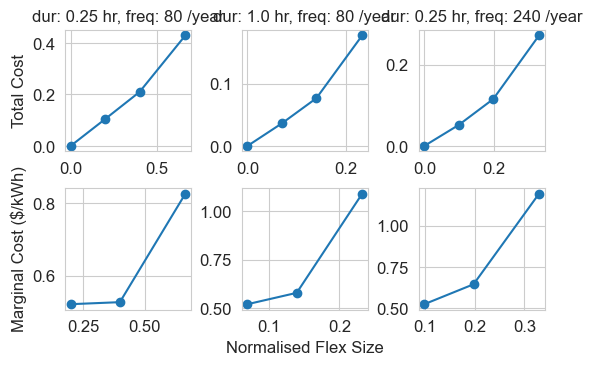

In [270]:
dur_freq_pairs = [(0.25, 80.0), (1.0, 80.0), (0.25, 240.0)]
fig, axs = plt.subplots(2, len(dur_freq_pairs), figsize=[6,4])
for i, (dur, freq) in enumerate(dur_freq_pairs):
    flex_size_max = res_df_dict[0.2].loc[dur, freq]
    cost_list = [0]
    flex_size_list = [0]
    for level in levels:
        comp_cost = comp_cost_res_df_dict[level].loc[dur, freq]
        energy_cost = energy_cost_res_df_dict[level].loc[dur, freq]
        
        flex_size = flex_size_max * level
        cost = (comp_cost + energy_cost)*flex_size
        cost_list.append(cost)
        flex_size_list.append(flex_size)
    
    flex_size_list = np.array(flex_size_list)
    cost_list = np.array(cost_list)
    axs[0, i].plot(flex_size_list, cost_list, marker = 'o')
    axs[0, i].set_title(f'dur: {dur} hr, freq: {int(freq)} /year', fontsize=12)
    
    # get the incremental cost curve/marginal cost curve
    incremental_cost_list = np.diff(cost_list) / np.diff(flex_size_list)
    axs[1, i].plot(flex_size_list[1:], incremental_cost_list, marker = 'o')
    
axs[1, 1].set_xlabel('Normalised Flex Size')
axs[0, 0].set_ylabel('Total Cost')
axs[1, 0].set_ylabel('Marginal Cost ($/kWh)')

# adjust the space between subplots
fig.subplots_adjust(wspace=0.4, hspace=0.3, top=0.9, bottom=0.2, left=0.1, right=0.9)

In [271]:
flex_size_max

0.3294913720250984